### Create Spark Session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

C:\ProgramData\Anaconda3\lib\site-packages\pyspark\context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


### Define nested json schema and define data structure

In [2]:
from pyspark.sql.functions import from_json, col, split, trim
from pyspark.sql.types import *


address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),  # string, to parse next
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])


df = spark.read.json("cc_sample_transaction.json")


df1 = df.withColumn("personal_detail_struct", from_json(col("personal_detail"), personal_detail_schema))


df2 = df1.withColumn("address_struct", from_json(col("personal_detail_struct.address"), address_schema))


df_flat = df2.select(
    "Unnamed: 0", "trans_date_trans_time", "cc_bic", "cc_num", "merchant",
    "category", "amt", "trans_num", "merch_lat", "merch_long", "merch_zipcode",
    "is_fraud", "merch_eff_time", "merch_last_update_time",
    col("personal_detail_struct.person_name").alias("person_name"),
    col("personal_detail_struct.gender").alias("gender"),
    col("personal_detail_struct.lat").alias("lat"),
    col("personal_detail_struct.long").alias("long"),
    col("personal_detail_struct.city_pop").alias("city_pop"),
    col("personal_detail_struct.job").alias("job"),
    col("personal_detail_struct.dob").alias("dob"),
    col("address_struct.street").alias("street"),
    col("address_struct.city").alias("city"),
    col("address_struct.state").alias("state"),
    col("address_struct.zip").alias("zip")
)


df_flat = df_flat.select([
    trim(col(c)).alias(c) if dict(df_flat.dtypes)[c] == 'string' else col(c)
    for c in df_flat.columns
])

df_flat.createOrReplaceTempView("raw_transaction")

In [3]:
spark.sql('select * from raw_transaction limit 10').show()

+----------+---------------------+-----------+----------------+--------------------+-------------+------+--------------------+------------------+------------------+-------------+--------+----------------+----------------------+--------------------+------+-------+------------------+--------+--------------------+----------+--------------------+--------------+-----+-----+
|Unnamed: 0|trans_date_trans_time|     cc_bic|          cc_num|            merchant|     category|   amt|           trans_num|         merch_lat|        merch_long|merch_zipcode|is_fraud|  merch_eff_time|merch_last_update_time|         person_name|gender|    lat|              long|city_pop|                 job|       dob|              street|          city|state|  zip|
+----------+---------------------+-----------+----------------+--------------------+-------------+------+--------------------+------------------+------------------+-------------+--------+----------------+----------------------+--------------------+------+-

### Data cleaning and mask/encrypt PII column :-
<br>
<li>Remove non-alphabets between person_name</li>
<li>Extract first and last name from person_name</li>
<li>Apply PII column encryption (for e.g; cc_num, cc_bic columns ) 

In [4]:
spark.sql(f"""
CREATE OR REPLACE TEMP VIEW transaction_cleaned_1 AS
WITH cleaned_person_name AS (
SELECT 
  *,
  TRIM(REGEXP_REPLACE(REGEXP_REPLACE(person_name, '[^a-zA-Z]', ' '), ' +', ' ')) as cleaned_person_name
FROM raw_transaction
)
SELECT 
  *,
  MD5(cc_num) AS cc_num_hashed,
  MD5(cc_bic) AS cc_bic_hashed,
  SPLIT(cleaned_person_name, ' ')[0] AS first,
  SPLIT(cleaned_person_name, ' ')[1] AS last
FROM cleaned_person_name
""")

spark.sql(f"""
select cc_num_hashed, cc_bic_hashed, person_name, first, last 
from transaction_cleaned_1
limit 10
""").show(truncate=False)

+--------------------------------+--------------------------------+------------------------+---------+--------+
|cc_num_hashed                   |cc_bic_hashed                   |person_name             |first    |last    |
+--------------------------------+--------------------------------+------------------------+---------+--------+
|25ffb48bcb500b9766de3ab9ffbd0c3d|717da7b7cb9c0fe07f8df880c423ed28|Jennifer,Banks,eeeee    |Jennifer |Banks   |
|f4a3764e613a960cec0c642bc165a937|cc46be3d3c8227dfc62d87971567b459|Stephanie,Gill,eeeee    |Stephanie|Gill    |
|006a4cb14dc3c2501cd3d4794648f2c9|bbb93ef26e3c101ff11cdd21cab08a94|Edward@Sanchez          |Edward   |Sanchez |
|7550ed0a66f447f072d818e17bdb18e8|a2db0453b6ed6d28698e8d090afa6334|Jeremy/White, !         |Jeremy   |White   |
|c4535cc0eb7559cbceabcb9d174490ca|cb5919f66932f8a3532306ac7e223500|Tyler@Garcia            |Tyler    |Garcia  |
|3d361d9cabbe1b9827808b2dcb1332be|cb5919f66932f8a3532306ac7e223500|Jennifer,Conner,eeeee   |Jennifer |Co

### Apply conditional logic for timestamp convertion based on length of unix time

In [5]:
spark.sql(f"""
CREATE OR REPLACE TEMP VIEW transaction_cleaned_2 AS
WITH ts_converted AS (
  SELECT
    *,
    CASE 
      WHEN length(merch_last_update_time) = 10 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_last_update_time AS BIGINT)), 'Asia/Singapore')
      WHEN length(merch_last_update_time) = 13 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_last_update_time AS BIGINT) / 1000), 'Asia/Singapore')
      WHEN length(merch_last_update_time) = 14 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_last_update_time AS BIGINT) / 100000), 'Asia/Singapore')
      WHEN length(merch_last_update_time) = 15 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_last_update_time AS BIGINT) / 10000), 'Asia/Singapore')
      WHEN length(merch_last_update_time) = 16 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_last_update_time AS BIGINT) / 1000000), 'Asia/Singapore')
      ELSE NULL
    END AS merch_last_update_ts,
    CASE 
      WHEN length(merch_eff_time) = 10 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_eff_time AS BIGINT)), 'Asia/Singapore')
      WHEN length(merch_eff_time) = 13 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_eff_time AS BIGINT) / 1000), 'Asia/Singapore')
      WHEN length(merch_eff_time) = 14 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_eff_time AS BIGINT) / 100000), 'Asia/Singapore')
      WHEN length(merch_eff_time) = 15 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_eff_time AS BIGINT) / 10000), 'Asia/Singapore')
      WHEN length(merch_eff_time) = 16 THEN 
        from_utc_timestamp(to_timestamp(CAST(merch_eff_time AS BIGINT) / 1000000), 'Asia/Singapore')
      ELSE NULL
    END AS merch_eff_ts
  FROM transaction_cleaned_1
)
SELECT 
  *,
  date_format(merch_last_update_ts, 'yyyy-MM-dd HH:mm.SSSSSS Z') AS merch_last_update_formatted,
  date_format(merch_eff_ts, 'yyyy-MM-dd HH:mm.SSSSSS Z') AS merch_eff_formatted
FROM ts_converted
""")

spark.sql(f"""
SELECT 
  merch_last_update_ts, 
  date_format(merch_last_update_ts, 'yyyy-MM-dd HH:mm.SSSSSS Z') AS merch_last_update_formatted,
  merch_eff_ts,
  date_format(merch_eff_ts, 'yyyy-MM-dd HH:mm.SSSSSS Z') AS merch_eff_formatted
FROM transaction_cleaned_2
limit 10
""").show(truncate=False)


+-----------------------+-----------------------------+--------------------------+-----------------------------+
|merch_last_update_ts   |merch_last_update_formatted  |merch_eff_ts              |merch_eff_formatted          |
+-----------------------+-----------------------------+--------------------------+-----------------------------+
|2012-01-01 16:00:18.666|2012-01-01 16:00.666000 +0800|2012-01-01 16:00:18.798532|2012-01-01 16:00.798532 +0800|
|null                   |null                         |2012-01-01 16:00:44.86796 |2012-01-01 16:00.867960 +0800|
|2012-01-01 16:00:51.286|2012-01-01 16:00.286000 +0800|2012-01-01 16:00:51.50684 |2012-01-01 16:00.506840 +0800|
|2012-01-01 16:01:16.365|2012-01-01 16:01.365000 +0800|2012-01-01 16:01:16.794698|2012-01-01 16:01.794698 +0800|
|null                   |null                         |2012-01-01 16:03:06.746376|2012-01-01 16:03.746376 +0800|
|2012-01-01 16:04:08.483|2012-01-01 16:04.483000 +0800|2012-01-01 16:04:08.271406|2012-01-01 16:

### Enforce schema on cleaned data and store in temporary table

In [6]:
spark.sql(f"""
CREATE OR REPLACE TEMP VIEW std_transaction AS
SELECT
  CAST(`Unnamed: 0` AS STRING) AS `Unnamed: 0`,
  CAST(TO_TIMESTAMP(trans_date_trans_time, 'yyyy-MM-dd HH:mm:ss') AS TIMESTAMP) AS trans_date_trans_time,
  CAST(cc_num_hashed AS STRING) AS cc_num,
  CAST(merchant AS STRING) AS merchant,
  CAST(category AS STRING) AS category,
  CAST(amt AS DOUBLE) AS amt,
  CAST(first AS STRING) AS first,
  CAST(last AS STRING) AS last,
  CAST(gender AS STRING) AS gender,
  CAST(street AS STRING) AS street,
  CAST(city AS STRING) AS city,
  CAST(state AS STRING) AS state,
  CAST(zip AS INT) AS zip,
  CAST(lat AS DOUBLE) AS lat,
  CAST(long AS DOUBLE) AS long,
  CAST(city_pop AS INT) AS city_pop,
  CAST(job AS STRING) AS job,
  CAST(TO_DATE(dob, 'yyyy-MM-dd') AS DATE) AS dob,
  CAST(trans_num AS STRING) AS trans_num,
  CAST(merch_lat AS DOUBLE) AS merch_lat,
  CAST(merch_long AS DOUBLE) AS merch_long,
  CAST(is_fraud AS STRING) AS is_fraud,
  CAST(merch_zipcode AS STRING) AS merch_zipcode,
  merch_last_update_formatted AS merch_last_update_time,
  merch_eff_formatted AS merch_eff_time,
  CAST(cc_bic_hashed AS STRING) AS cc_bic
FROM transaction_cleaned_2
""")

DataFrame[]

### Data Analysis and Visualization
<br>
<li> Due to insufficient resource, therefore only sampling of 100k records being used for analysis</li>
    

In [7]:
import pandas as pd

df = spark.sql('select * from std_transaction limit 100000').toPandas()

df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_last_update_time,merch_eff_time,cc_bic
0,0,2019-01-01 00:00:18,25ffb48bcb500b9766de3ab9ffbd0c3d,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705,2012-01-01 16:00.666000 +0800,2012-01-01 16:00.798532 +0800,717da7b7cb9c0fe07f8df880c423ed28
1,1,2019-01-01 00:00:44,f4a3764e613a960cec0c642bc165a937,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,None,None,2012-01-01 16:00.867960 +0800,cc46be3d3c8227dfc62d87971567b459
2,2,2019-01-01 00:00:51,006a4cb14dc3c2501cd3d4794648f2c9,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236,2012-01-01 16:00.286000 +0800,2012-01-01 16:00.506840 +0800,bbb93ef26e3c101ff11cdd21cab08a94
3,3,2019-01-01 00:01:16,7550ed0a66f447f072d818e17bdb18e8,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,None,2012-01-01 16:01.365000 +0800,2012-01-01 16:01.794698 +0800,a2db0453b6ed6d28698e8d090afa6334
4,4,2019-01-01 00:03:06,c4535cc0eb7559cbceabcb9d174490ca,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844,None,2012-01-01 16:03.746376 +0800,cb5919f66932f8a3532306ac7e223500


In [8]:
import plotly.express as px
from IPython.display import Image

### Distribution of Transaction Amounts

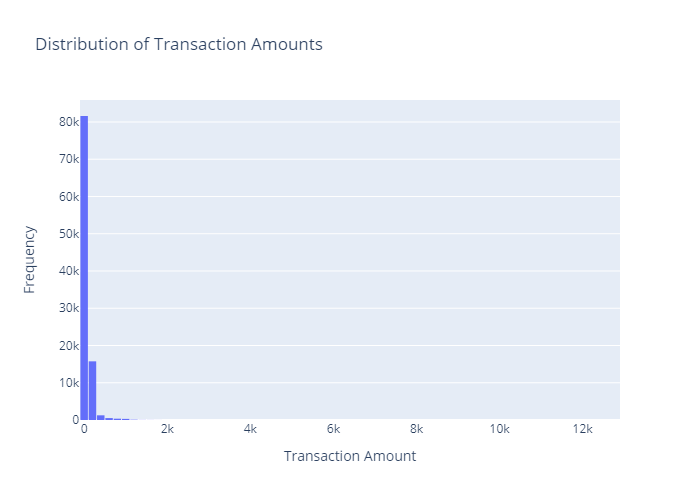

In [9]:
fig = px.histogram(df, x='amt', nbins=100, 
                   title='Distribution of Transaction Amounts',
                   labels={'amt': 'Transaction Amount'})
fig.update_layout(yaxis_title='Frequency',
                  bargap=0.1,
                  showlegend=False)

fig.write_image('plot.png')

Image('plot.png')

### Transaction Volume Over Time

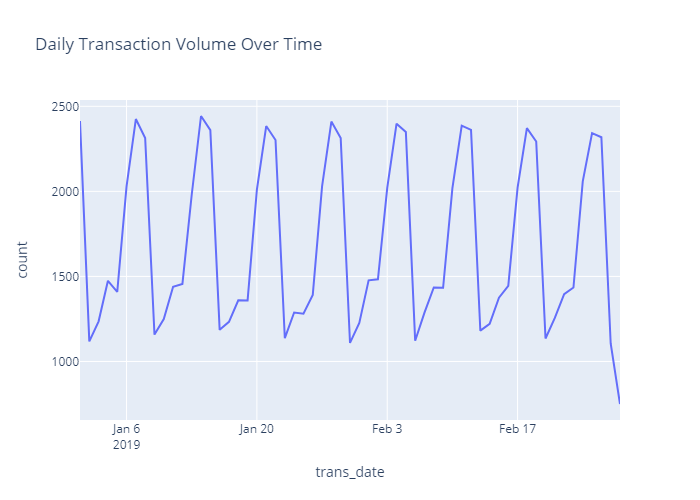

In [10]:
df['trans_date'] = pd.to_datetime(df['trans_date_trans_time']).dt.date
daily_txn = df.groupby('trans_date').size().reset_index(name='count')

import plotly.express as px
fig = px.line(daily_txn, x='trans_date', y='count',
              title='Daily Transaction Volume Over Time')

fig.write_image('plot.png')

Image('plot.png')

### Fraud vs. Non-Fraud Over Time

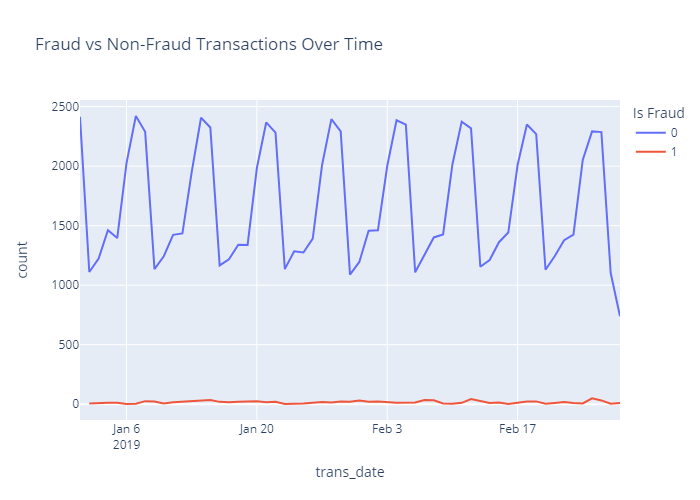

In [11]:
df['trans_date'] = pd.to_datetime(df['trans_date_trans_time']).dt.date
fraud_daily = df.groupby(['trans_date', 'is_fraud']).size().reset_index(name='count')

fig = px.line(fraud_daily, x='trans_date', y='count', color='is_fraud',
              title='Fraud vs Non-Fraud Transactions Over Time',
              labels={'is_fraud': 'Is Fraud'})

fig.write_image('plot.png')

Image('plot.png')

### Day of Week Fraud Count

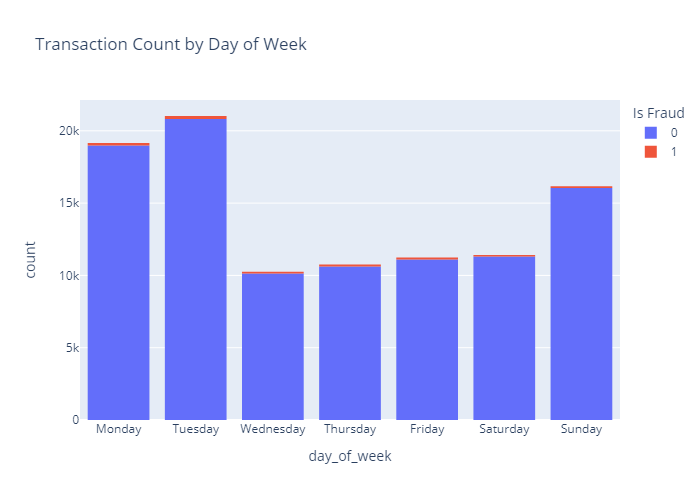

In [12]:
df['day_of_week'] = pd.to_datetime(df['trans_date_trans_time']).dt.day_name()

fig = px.histogram(df, x='day_of_week', color='is_fraud',
                   category_orders={'day_of_week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']},
                   title='Transaction Count by Day of Week',
                   labels={'is_fraud': 'Is Fraud'})

fig.write_image('plot.png')

Image('plot.png')

### Average Amount by Category

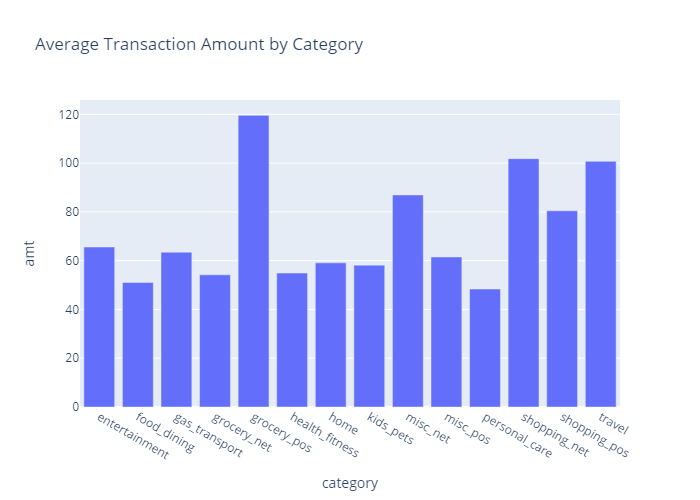

In [13]:
fig = px.bar(df.groupby('category', as_index=False)['amt'].mean(), 
             x='category', y='amt', 
             title='Average Transaction Amount by Category')

fig.write_image('plot.png')

Image('plot.png')

### Fraud Count by Gender

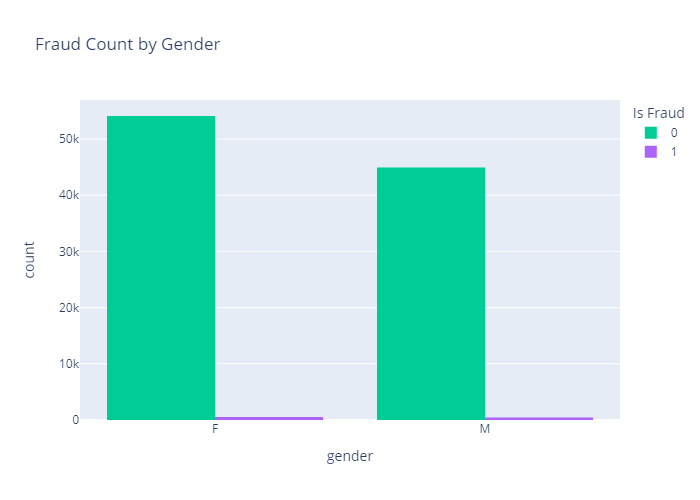

In [14]:
fig = px.histogram(df, x='gender', color='is_fraud',
                   barmode='group',
                   title='Fraud Count by Gender',
                   category_orders={'is_fraud': [0, 1]},
                   labels={'is_fraud': 'Is Fraud'})

fig.write_image('plot.png')

Image('plot.png')

### Top 10 Merchants with Most Fraud

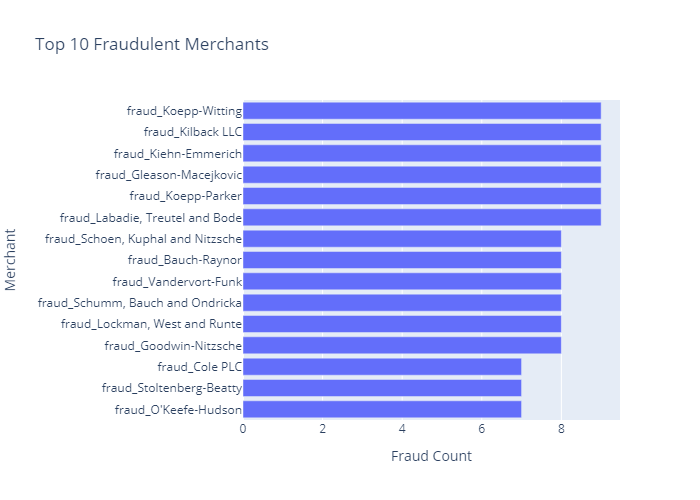

In [15]:
top_merchants = df[df['is_fraud'] == '1']['merchant'].value_counts().nlargest(15)
top_df = top_merchants.reset_index()
top_df.columns = ['merchant', 'count']

fig = px.bar(top_df, x='count', y='merchant', orientation='h',
             title='Top 10 Fraudulent Merchants',
             category_orders={'merchant': top_df['merchant'].tolist()})  # force order
fig.update_layout(yaxis_title='Merchant', xaxis_title='Fraud Count')

fig.write_image('plot.png')

Image('plot.png')

### Fraud Distribution by State

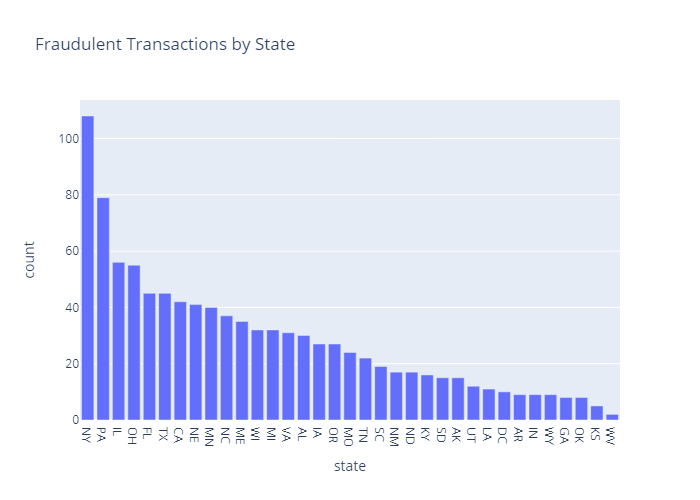

In [16]:
fraud_by_state = df[df['is_fraud'] == '1']['state'].value_counts().reset_index()
fraud_by_state.columns = ['state', 'count']

fig = px.bar(fraud_by_state, x='state', y='count',
             title='Fraudulent Transactions by State')

fig.write_image('plot.png')

Image('plot.png')

### Fraud Location Scatter Plot (Lat/Long)

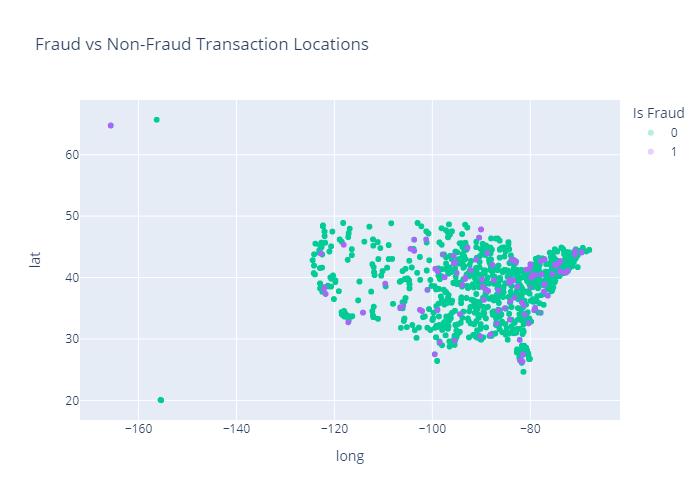

In [17]:
fig = px.scatter(df, x='long', y='lat', color='is_fraud',
                 title='Fraud vs Non-Fraud Transaction Locations',
                 opacity=0.3,
                 color_discrete_map={0: 'blue', 1: 'red'},
                 labels={'is_fraud': 'Is Fraud'})

fig.write_image('plot.png')

Image('plot.png')

### Average Amount by Gender

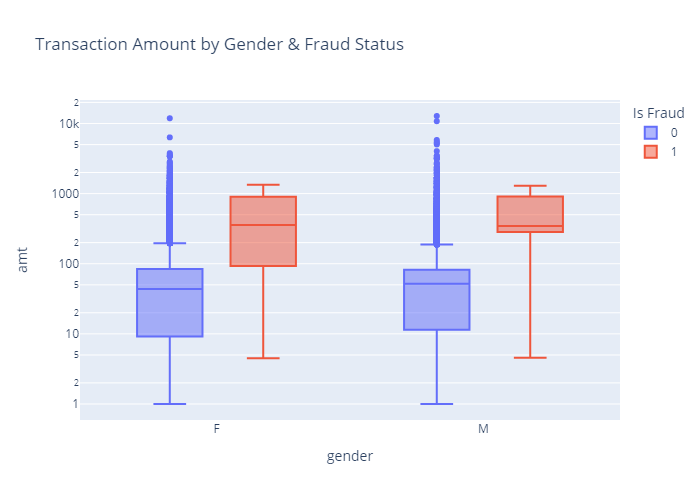

In [18]:
fig = px.box(df, x='gender', y='amt', color='is_fraud',
             title='Transaction Amount by Gender & Fraud Status',
             log_y=True,
             labels={'is_fraud': 'Is Fraud'})

fig.write_image('plot.png')

Image('plot.png')

### City Population vs Transaction Amount 

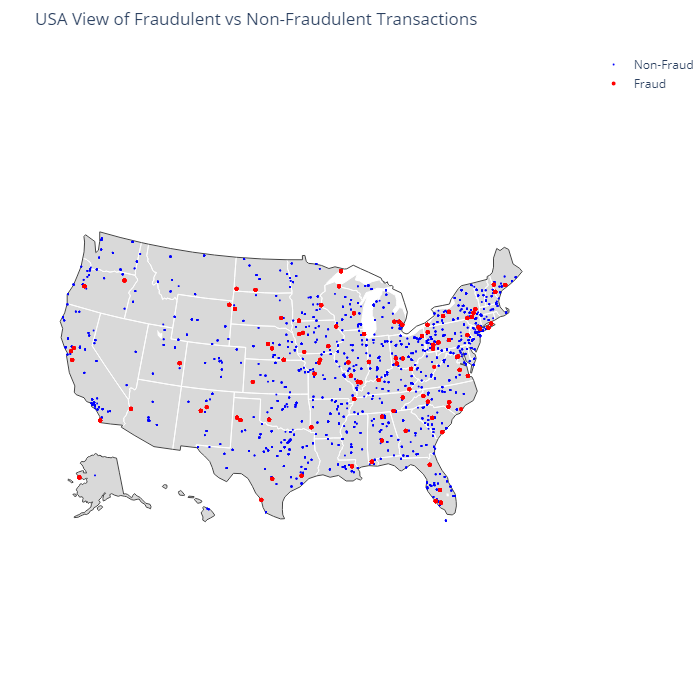

In [19]:
import plotly.graph_objects as go
from IPython.display import Image

fraud = df[df['is_fraud'] == '1']
non_fraud = df[df['is_fraud'] == '0'].sample(5000)

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon = non_fraud['long'],
    lat = non_fraud['lat'],
    mode = 'markers',
    marker=dict(size=2, color='blue'),
    name = 'Non-Fraud'
))

fig.add_trace(go.Scattergeo(
    lon = fraud['long'],
    lat = fraud['lat'],
    mode = 'markers',
    marker=dict(size=4, color='red'),
    name = 'Fraud'
))

fig.update_geos(
    scope="usa",
    projection_type="albers usa",
    showland=True,
    landcolor="rgb(217, 217, 217)",
    oceancolor="LightBlue",
    showocean=True,
    showcountries=True
)

fig.update_layout(
    title='USA View of Fraudulent vs Non-Fraudulent Transactions',
    height=700,
    margin=dict(l=0, r=0, t=50, b=0),
    showlegend=True
)

fig.write_image('plot.png')

Image('plot.png')
